In [62]:
%load_ext autoreload
%autoreload 2

import h5py
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.optimize import curve_fit

mpl.style.use('default')
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.titlesize'] = 20
mpl.rcParams['figure.figsize'] = [6.4*1.2,4.8*1.2]
mpl.rcParams['axes.labelsize'] = 30
mpl.rcParams['axes.titlesize'] = 30
mpl.rcParams['lines.marker'] = 's'
mpl.rcParams['lines.linestyle'] = ''
mpl.rcParams['lines.markersize'] = 12
mpl.rcParams['errorbar.capsize'] = 12
mpl.rcParams['xtick.labelsize'] = mpl.rcParams['ytick.labelsize'] = 22
mpl.rcParams['xtick.major.size'] = mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['xtick.top']=mpl.rcParams['ytick.right']=True
mpl.rcParams['xtick.direction']=mpl.rcParams['ytick.direction']='in'
mpl.rcParams['legend.fontsize'] = 24
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
import util as yu
yu.flag_fast=True

path='dat/NST_b_cD96.h5'
with h5py.File(path) as f:
    t=(f['diags/N/data/N2_N2'][:,:,0]+f['diags/N/data/N2_N2'][:,:,1])/2
    C2pt_dat=np.real(t)
    
    print(f.keys())
    print(f['diags/'].keys())
    print(f['diags/NJN'].keys())
    print(f['diags/NJN/data'].keys())
    print(f['diags/NJN/data/gS_j+_deltat_10'])
    tfs=[int(ele.split('_')[-1]) for ele in f['diags/NJN/data'].keys()]
    tfs=list(set(tfs))
    tfs.sort()
    print(tfs)
    
    C3pt_dat_dic={tf:np.real(f['diags/NJN/data/gS_j+_deltat_{}'.format(tf)][:]) for tf in tfs}
    print(C3pt_dat_dic[12].shape)
    
    C2pt_dat_dic={tf:np.real(f['diags/N_correlated_NJN/data/dt{}_twop'.format(tf)][:]) for tf in tfs}
    print(C2pt_dat_dic[12].shape)

C2pt_jk=yu.jackknife(C2pt_dat)
C3pt_jk_dic={tf:yu.jackknife(C3pt_dat_dic[tf]) for tf in tfs}
C2pt_jk_dic={tf:yu.jackknife(C2pt_dat_dic[tf]) for tf in tfs}

aMUL=0.00054
ZP=0.493
aLat=0.05692 # lattice spacing a in fm
aInvLat=1/aLat*197.3/1000 # a^{-1} in GeV


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
<KeysViewHDF5 ['VEV', 'cfgs', 'diags']>
<KeysViewHDF5 ['N', 'N-j', 'NJN', 'N_correlated_NJN']>
<KeysViewHDF5 ['data']>
<KeysViewHDF5 ['gS_j+_deltat_10', 'gS_j+_deltat_12', 'gS_j+_deltat_14', 'gS_j+_deltat_16', 'gS_j+_deltat_18', 'gS_j+_deltat_20', 'gS_j+_deltat_22', 'gS_j+_deltat_24', 'gS_j+_deltat_26', 'gS_j+_deltat_8']>
<HDF5 dataset "gS_j+_deltat_10": shape (494, 11), type "<f4">
[8, 10, 12, 14, 16, 18, 20, 22, 24, 26]
(494, 13)
(494,)


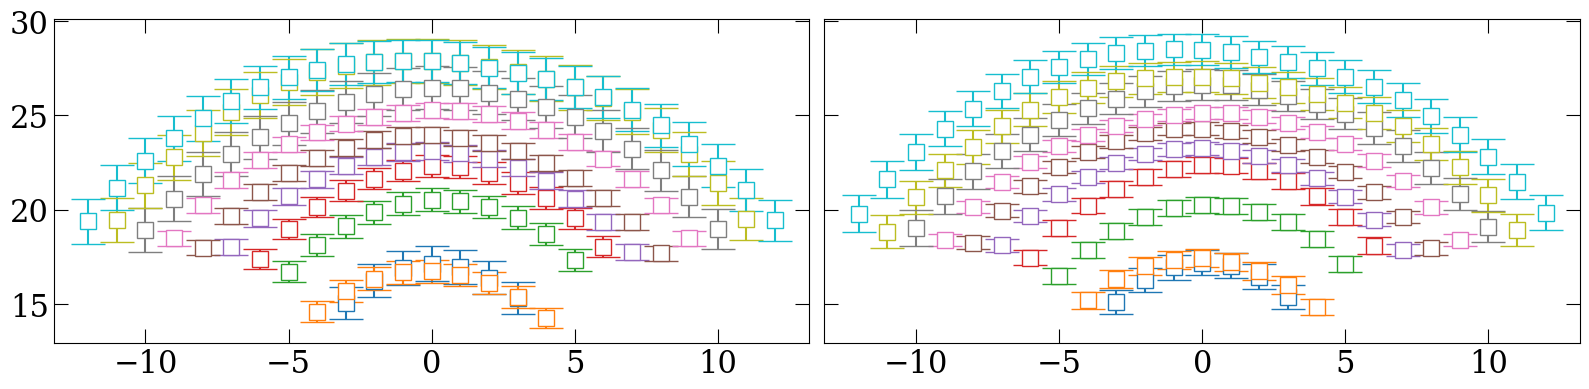

In [117]:
(Nrow,Ncol)=(1,2); (Lrow,Lcol)=(4,8)
fig, axs = plt.subplots(Nrow, Ncol, figsize=(Lcol*Ncol, Lrow*Nrow), squeeze=False, sharex=True, sharey=True)

irow=0; icol=0
for tf in tfs:
    tcList=np.arange(tf+1)
    ratio_jk=[C3pt[tcList]/C2pt[tf] for C2pt,C3pt in zip(C2pt_jk,C3pt_jk_dic[tf])]
    ratio_mean,ratio_err,ratio_cov=yu.jackMEC(ratio_jk)
    xUnit=1; yUnit=aMUL*aInvLat*1000
    plt_x=(tcList[1:tf]-tf//2)*xUnit; plt_y=ratio_mean[1:tf]*yUnit; plt_err=ratio_err[1:tf]*yUnit
    axs[irow,icol].errorbar(plt_x,plt_y,plt_err,fmt='s',mfc='white')
    
irow=0; icol=1
for tf in tfs:
    tcList=np.arange(tf+1)
    ratio_jk=[C3pt[tcList]/C2pt for C2pt,C3pt in zip(C2pt_jk_dic[tf],C3pt_jk_dic[tf])]
    ratio_mean,ratio_err,ratio_cov=yu.jackMEC(ratio_jk)
    xUnit=1; yUnit=aMUL*aInvLat*1000
    plt_x=(tcList[1:tf]-tf//2)*xUnit; plt_y=ratio_mean[1:tf]*yUnit; plt_err=ratio_err[1:tf]*yUnit
    axs[irow,icol].errorbar(plt_x,plt_y,plt_err,fmt='s',mfc='white')

plt.tight_layout()

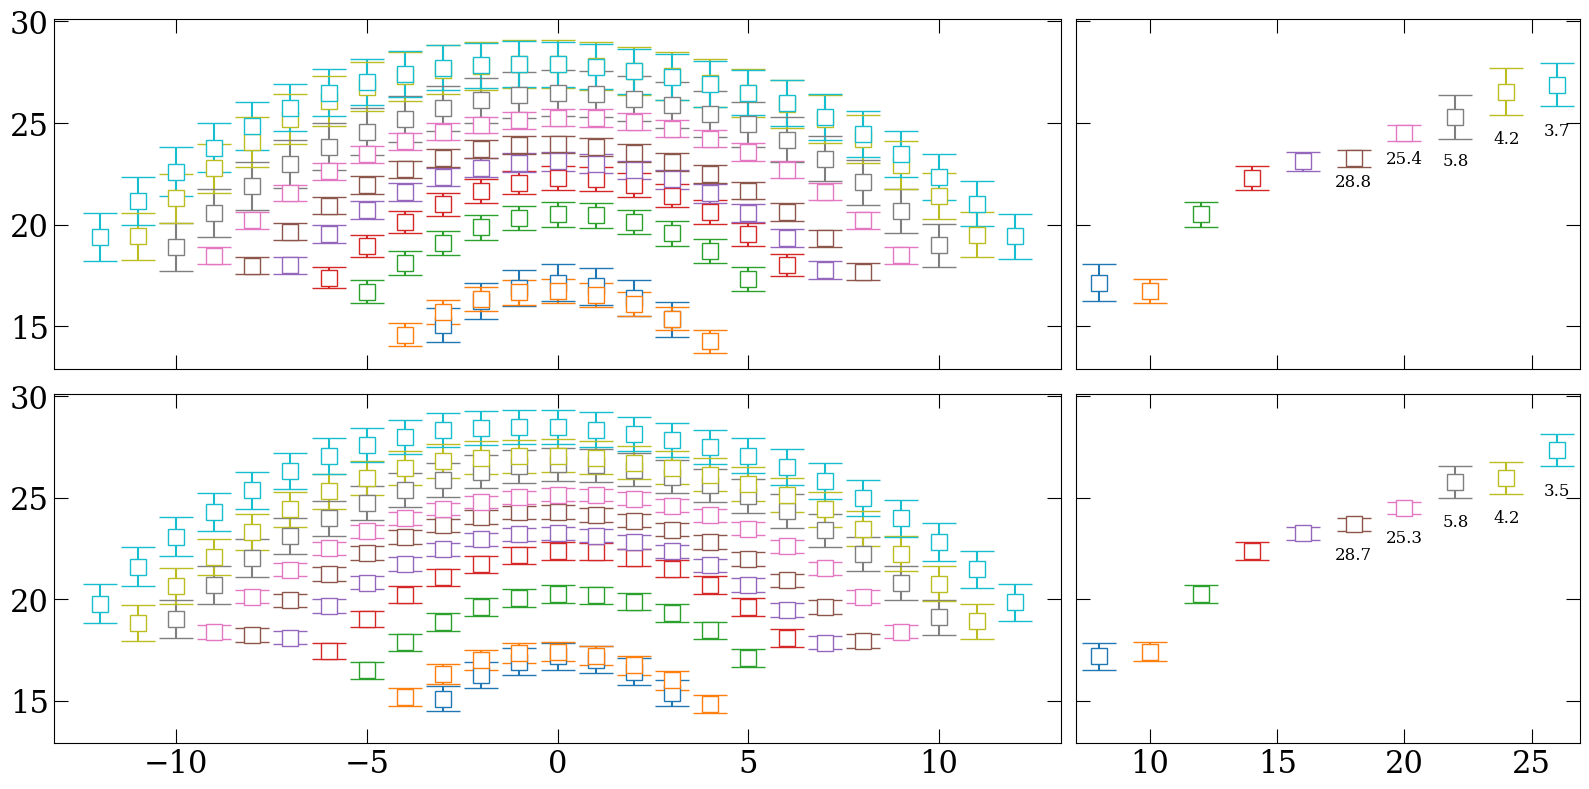

In [139]:
(Nrow,Ncol)=(2,2); (Lrow,Lcol)=(4,8)
fig, axs = plt.subplots(Nrow, Ncol, figsize=(Lcol*Ncol, Lrow*Nrow), squeeze=False, gridspec_kw={'width_ratios': [2, 1]}, sharex='col', sharey=True)

tau_plat=8
chi2Size=12
xUnit=1; yUnit=aMUL*aInvLat*1000
for irow,case in enumerate(['ratio','coRatio']):
    for tf in tfs:
        icol=0
        tcList=np.arange(tf+1)
        ratio_jk=[C3pt[tcList]/C2pt[tf] for C2pt,C3pt in zip(C2pt_jk,C3pt_jk_dic[tf])] \
            if case=='ratio' else [C3pt[tcList]/C2pt for C2pt,C3pt in zip(C2pt_jk_dic[tf],C3pt_jk_dic[tf])]
        ratio_jk=np.array(ratio_jk)
        ratio_mean,ratio_err,ratio_cov=yu.jackMEC(ratio_jk)
        plt_x=(tcList[1:tf]-tf//2)*xUnit; plt_y=ratio_mean[1:tf]*yUnit; plt_err=ratio_err[1:tf]*yUnit
        axs[irow,icol].errorbar(plt_x,plt_y,plt_err,fmt='s',mfc='white')
        
        icol=1
        if tf<tau_plat*2+2:
            plt_x=tf*xUnit; plt_y=ratio_mean[tf//2]*yUnit; plt_err=ratio_err[tf//2]*yUnit
            axs[irow,icol].errorbar(plt_x,plt_y,plt_err,fmt='s',mfc='white')
        else:
            tcList=np.arange(tau_plat,tf-tau_plat+1)
            def fitfunc(pars):
                return np.zeros(len(tcList))+pars[0]
            def estimator(pars):
                return [pars[0]]
            y_jk=ratio_jk[:,tcList]; p0=[ratio_jk[0,tf//2]]
            obs_jk,chi2R,Ndof=yu.jackfit(fitfunc,y_jk,p0,estimator=estimator)
            (obs_mean,obs_err)=yu.jackME(obs_jk)
            plt_x=tf*xUnit; plt_y=obs_mean[0]*yUnit; plt_err=obs_err[0]*yUnit
            axs[irow,icol].errorbar(plt_x,plt_y,plt_err,fmt='s',mfc='white')
            ylim=axs[irow,icol].get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
            axs[irow,icol].annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),size=chi2Size,ha='center')
            
plt.tight_layout()

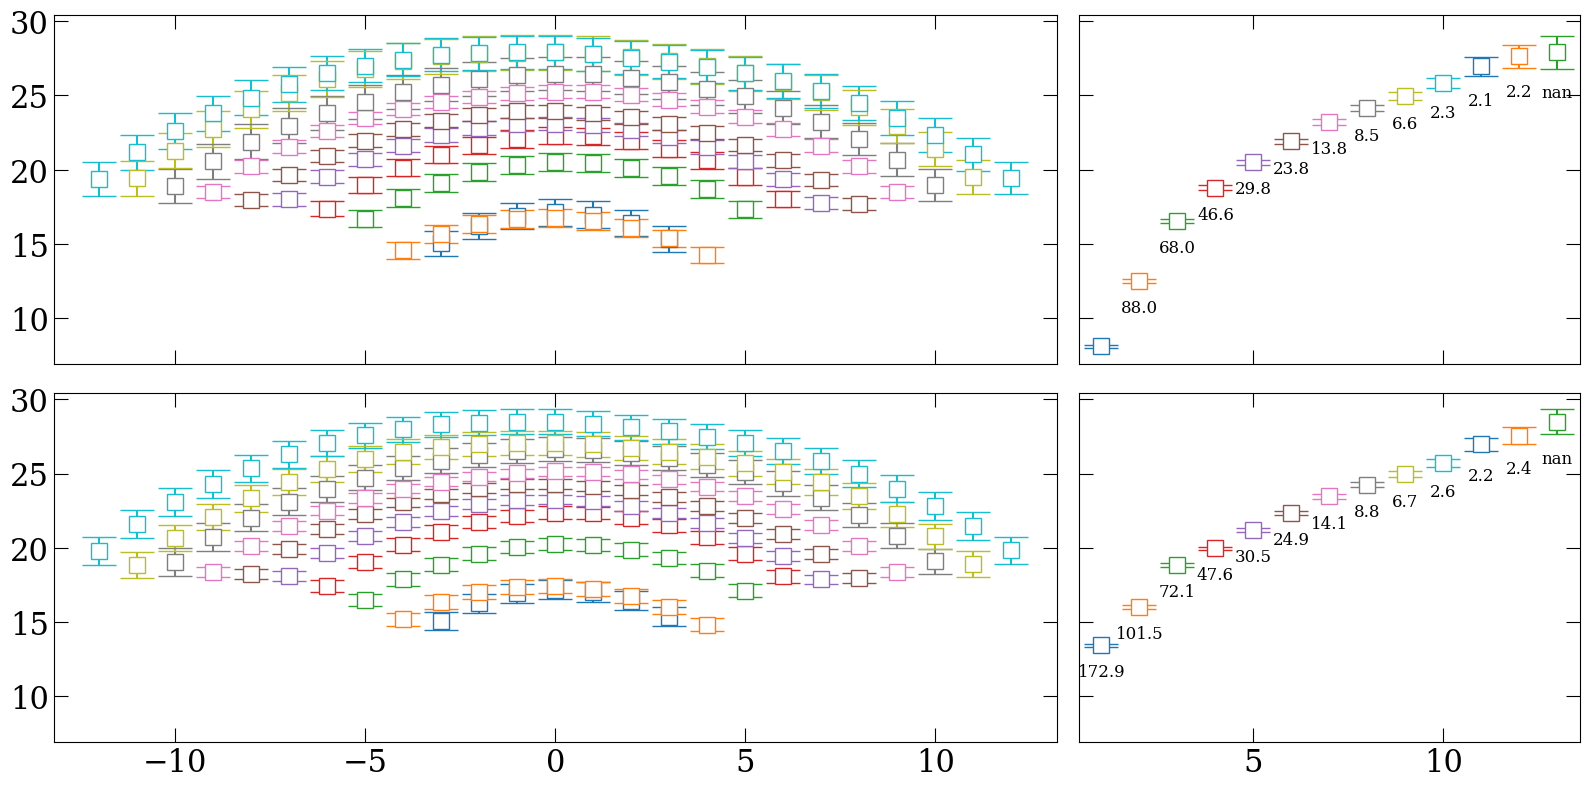

In [130]:
(Nrow,Ncol)=(2,2); (Lrow,Lcol)=(4,8)
fig, axs = plt.subplots(Nrow, Ncol, figsize=(Lcol*Ncol, Lrow*Nrow), squeeze=False, gridspec_kw={'width_ratios': [2, 1]}, sharex='col', sharey=True)

tau_plats=np.arange(1,13+1)
chi2Size=12
xUnit=1; yUnit=aMUL*aInvLat*1000
for irow,case in enumerate(['ratio','coRatio']):
    ratio_jk_dic={}
    for tf in tfs:
        icol=0
        tcList=np.arange(tf+1)
        ratio_jk=[C3pt[tcList]/C2pt[tf] for C2pt,C3pt in zip(C2pt_jk,C3pt_jk_dic[tf])] \
            if case=='ratio' else [C3pt[tcList]/C2pt for C2pt,C3pt in zip(C2pt_jk_dic[tf],C3pt_jk_dic[tf])]
        ratio_jk=np.array(ratio_jk)
        ratio_jk_dic[tf]=ratio_jk
        ratio_mean,ratio_err,ratio_cov=yu.jackMEC(ratio_jk)
        plt_x=(tcList[1:tf]-tf//2)*xUnit; plt_y=ratio_mean[1:tf]*yUnit; plt_err=ratio_err[1:tf]*yUnit
        axs[irow,icol].errorbar(plt_x,plt_y,plt_err,fmt='s',mfc='white')
        
    icol=1
    for tau_plat in tau_plats:
        tcList_dic={tf:np.arange(tau_plat,tf-tau_plat+1) for tf in tfs if tf-tau_plat+1>tau_plat}
        tfList=list(tcList_dic.keys()); tfList.sort()
        Ndata=np.sum([len(tcList_dic[tf]) for tf in tfList])
        def fitfunc(pars):
            return np.zeros(Ndata)+pars[0]
        def estimator(pars):
            return [pars[0]]
        ratio_jk=np.hstack([ratio_jk_dic[tf][:,tcList_dic[tf]] for tf in tfList])
        y_jk=ratio_jk; p0=[ratio_jk[0,Ndata//2]]
        obs_jk,chi2R,Ndof=yu.jackfit(fitfunc,y_jk,p0,estimator=estimator)
        (obs_mean,obs_err)=yu.jackME(obs_jk)
        plt_x=tau_plat*xUnit; plt_y=obs_mean[0]*yUnit; plt_err=obs_err[0]*yUnit
        axs[irow,icol].errorbar(plt_x,plt_y,plt_err,fmt='s',mfc='white')
        ylim=axs[irow,icol].get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
        axs[irow,icol].annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),size=chi2Size,ha='center')
            
plt.tight_layout()